# Project: Implied Volatility vs Realized Volatility for an Africa-Exposure ETF  
### with a West Africa Regime Overlay

---

The goal is testing whether implied volatility (IV) from options on an Africa-exposure ETF forecasts next-week realized volatility (RV), and how forecast errors vary across West Africa regimes defined by Naira (NGN) volatility.

Given my Nigerian background, AFK will be our option of focus since it has Pan-African exposure and EZA is South Africa focused. AFK and EZA are the only two ETFs that can be traded with in the America. 

In [9]:
#Before running this notebook, install the required packages by executing the following commands in a code cell:

# ---- Core finance & data libraries ----
#!pip install yfinance            # download market data
#!pip install pandas              # data handling
#!pip install numpy               # math & array operations
#!pip install matplotlib          # plotting (if you graph volatility)
#!pip install scipy               # numerical methods, e.g., Brent root-finding

# ---- Option pricing & implied volatility ----
#!pip install py_vollib           # Black–Scholes–Merton pricing + implied vol
# (if py_vollib gives compilation errors, use this instead)
#!pip install py_vollib-vectorized

# ---- Optional but recommended ----
#!pip install seaborn             # prettier charts (optional)
#!pip install plotly              # interactive graphs (optional)
#!pip install tqdm                # progress bars for loops
#!pip install requests            # for robust HTTP sessions

# ---- For fallback caching or file handling ----
#!pip install json5               # reading/writing JSON cache
#!pip install pathlib             # (usually built-in with Python ≥3.4)

**Implied Volatility (IV):**

Simplied volatility is the value of $\sigma $ that satisfies the **Black–Scholes option pricing formula** for a given market option price $ C_{\text{mkt}} $:

$$
C_{\text{mkt}} = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$

where

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + (r - q + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}
$$

and

- $C_{\text{mkt}} $ = option's market price 
- S_0 = current underlying price <!-- current market price -->
- K = strike price  <!-- fixed price (or exercised price) in option contract| for call - buy @ K & for put - sell @ K -->
- r = risk-free rate  <!-- continuously compounded annualized return of a risk-free asset -->
- q = dividend yield  <!-- ratio of a company's annual dividend payment to its stock price, which can influence the value of call & put options -->
- T = time to expiration (in years)  <!-- time remaining until the option’s expiration date, can be called "theta decay" -->
- N =  cumulative normal distribution <!-- probability that a standard normally distributed random variable is less than or equal to a given number of standard deviations from the mean -->

<!-- Note: The strike price is the fixed amount you will pay (or receive) in the future, while the present value is how much that future payment (and the option’s overall payoff) is worth today, after adjusting for time and interest.  -->

The **implied volatility** $\sigma_{\text{imp}}$ is found by *inverting* this equation — i.e., solving for $\sigma$ such that the model price equals the observed market price. Since $N(d_{1})$ and $N(d_{2})$ are nonlinear cumulative normal functions, there’s no analytical way to isolate σ symbolically. \

This means we cannot just “move terms around” like in normal algebra.

So instead, we invert the equation numerically — i.e., find the σ that makes the theoretical Black–Scholes price equal the observed market price. This is where Numerical inversion can be used.

$$f(σ)=C_{BS}​(S_0​,K,r,q,T,σ)−C_{mkt}$$

From here, find the root: 

$$f(σ_{imp}​)=0$$

Since we cannot do this analytically, a root-finding algorithm can be utilized. Our data provides IV already, but if we were to compute it ourselves, the *py_vollib* library would have been used. Example code would look like: 

In [10]:
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

option_price = 2.50   # market option price
S = 100.0             # spot
K = 105.0             # strike
t = 30/365            # time to expiry (years)
r = 0.05              # risk-free rate
q = 0.0               # dividend yield
flag = 'c'            # 'c' for call, 'p' for put

iv = implied_volatility(
    option_price,  # price
    S,             # spot
    K,             # strike
    t,             # <-- time first
    r,             # <-- then risk-free
    q,             # <-- then dividend
    flag           # <-- then 'c' or 'p'
)

print("Implied volatility:", iv)


Implied volatility: 0.37751241493004


**Realized Volatility (RV)** 

The **realized volatility** over a 5-day window measures how much the asset price actually fluctuated in that period.  
It is computed from daily log-returns and annualized to make it comparable with implied volatility.

#### Formula

$$
\text{RV}_{t \to t+5} = 
\sqrt{
\sum_{d=1}^{5} r_{t+d}^2 \cdot \frac{252}{5}
},
\quad 
r_{t+d} = \ln\!\left(\frac{S_{t+d}}{S_{t+d-1}}\right)
$$

Where:
- S_t = price of the underlying asset on day \(t\)
- r_{t+d} = daily log return
- 252 = approximate number of trading days per year
- 5 = number of days in the window (e.g., a trading week)
- $RV_{t \to t+5}$ = annualized realized volatility over the 5-day window

What is the relationship between IV and RV? 

#### Interpretation

- **Realized Volatility (RV):** reflects *actual* price fluctuations observed in historical data.  
- **Implied Volatility (IV):** reflects *expected* future volatility inferred from option prices.  

Comparing these two helps assess whether options are **over- or under-priced** relative to recent market behavior.


In [11]:
from pathlib import Path
import pandas as pd

root = Path.cwd()  # /Users/chidu/Downloads/Erdos_Africa
csv_path = root / "afk_options-overview-history-11-01-2025.csv"
print(csv_path.exists(), csv_path)  # should print: True /Users/chidu/...

df_afk = pd.read_csv(csv_path, sep=None, engine="python", parse_dates=["Date"])
print(df_afk.shape)


True /Users/chidu/Downloads/Erdos_Africa/afk_options-overview-history-11-01-2025.csv
(581, 10)


NameError: name 'iv_col' is not defined

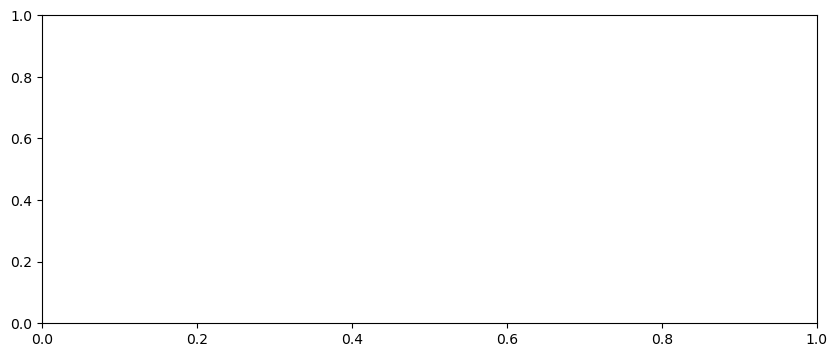

In [12]:
# How option-implied volatility evolved over our sample (the market’s expectation of future uncertainty).
# Spikes correspond to periods of perceived risk — possibly macro events or Naira instability.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(10, 4))

# Plot implied volatility
ax.plot(df_afk['Date'], df_afk[iv_col], color="#003366", linewidth=2)

# Labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Implied Volatility (%)')
ax.set_title('AFK Implied Volatility Over Time')

# 🔹 Horizontal guide lines every 5 percentage points
ax.yaxis.set_major_locator(MultipleLocator(5))      # main lines every 5%
ax.yaxis.set_minor_locator(AutoMinorLocator(2))     # minor lines between
ax.grid(which='major', axis='y', linestyle='-', alpha=0.35)
ax.grid(which='minor', axis='y', linestyle='--', alpha=0.25)

# 🔹 Denser x-axis dates
locator = mdates.AutoDateLocator(minticks=15, maxticks=40)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

plt.tight_layout()
plt.show()


/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


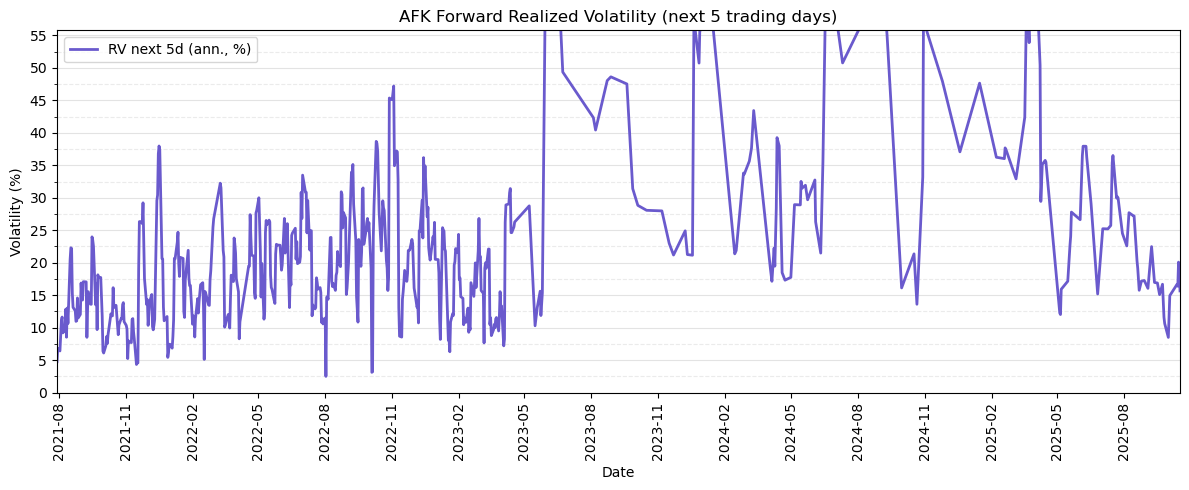

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

# -----------------------------
# Config (tweak if needed)
# -----------------------------
HORIZON_DAYS = 5          # RV over the next 5 trading days
START_OFFSET_DAYS = 0     # use 5 if you want the window to start 5 days after t
ANNUALIZATION = 252
USE_LOG_RETURNS = True

# -----------------------------
# Prep prices from df_afk
# -----------------------------
dfa = df_afk.copy()
dfa["Date"] = pd.to_datetime(dfa["Date"], errors="coerce")
dfa["Last"] = pd.to_numeric(dfa["Last"], errors="coerce")
dfa = (dfa.dropna(subset=["Date", "Last"])
          .sort_values("Date")
          .set_index("Date"))
dfa = dfa[~dfa.index.duplicated(keep="last")]  # guard against duplicate dates

# -----------------------------
# Forward Realized Volatility (%)
# -----------------------------
def forward_realized_vol_pct(prices: pd.Series,
                             horizon_days: int,
                             start_offset_days: int = 0,
                             annualization: int = 252,
                             use_log_returns: bool = True) -> pd.Series:
    """
    RV aligned at date t but computed over (t+1+offset ... t+horizon+offset).
    Returns annualized percent volatility.
    """
    r = np.log(prices).diff() if use_log_returns else prices.pct_change()
    rv_at_u = r.rolling(horizon_days).std(ddof=1) * np.sqrt(annualization) * 100.0  # backward-looking at u
    shift_back = -(horizon_days + start_offset_days)  # align to t
    return rv_at_u.shift(shift_back).rename(f"RV_next{horizon_days}d_pct")

rv_pct = forward_realized_vol_pct(dfa["Last"],
                                  horizon_days=HORIZON_DAYS,
                                  start_offset_days=START_OFFSET_DAYS,
                                  annualization=ANNUALIZATION,
                                  use_log_returns=USE_LOG_RETURNS).dropna()

# -----------------------------
# Plot: RV only
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(rv_pct.index, rv_pct.values, color="#6A5ACD", linewidth=2, label=f"RV next {HORIZON_DAYS}d (ann., %)")

ax.set_title(f"AFK Forward Realized Volatility (next {HORIZON_DAYS} trading days)")
ax.set_ylabel("Volatility (%)")
ax.set_xlabel("Date")

# Make RV readable: more horizontal lines
ax.yaxis.set_major_locator(MaxNLocator(nbins=12))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which="major", axis="y", linestyle="-", alpha=0.35)
ax.grid(which="minor", axis="y", linestyle="--", alpha=0.25)

# Date ticks as calendar (no hours) + vertical labels
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for lab in ax.get_xticklabels():
    lab.set_rotation(90)
    lab.set_ha("center")

# Sensible y-limits even if values are small
ymax = float(np.nanpercentile(rv_pct.values, 95)) if len(rv_pct) else 1.0
ax.set_ylim(0, max(1.0, ymax * 1.1))

ax.legend()
ax.margins(x=0)
plt.tight_layout()
plt.show()


/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


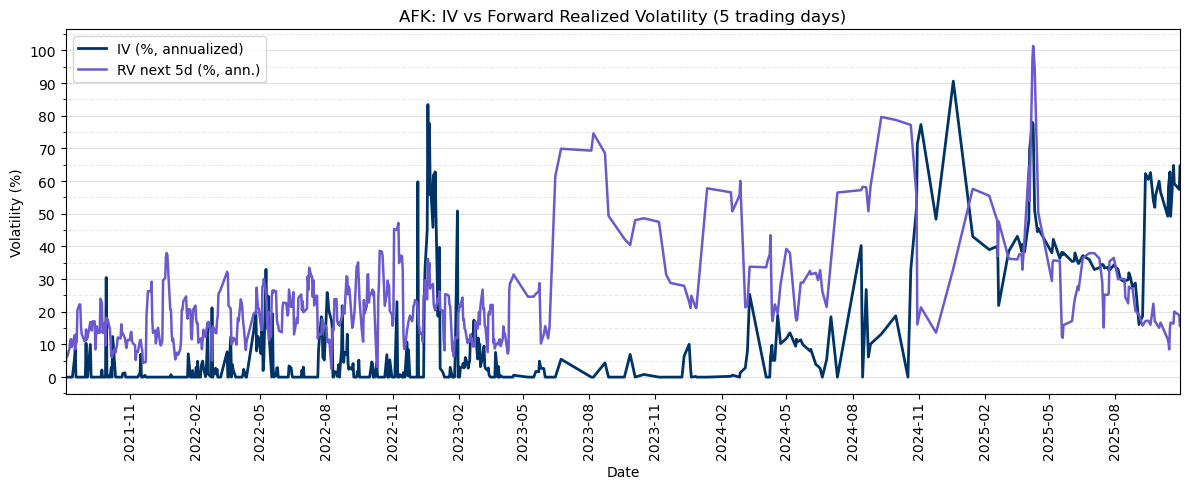

In [ ]:
# Direct visual comparison of expectations (IV) vs outcomes (RV).
# When IV > RV → market overestimated volatility
# When IV < RV → market underestimated volatility 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, NullLocator, NullFormatter

# ---------- IV: clean and index by Date ----------
iv_df = df_afk.copy()
iv_df['Date'] = pd.to_datetime(iv_df['Date'], errors='coerce')
iv_df = iv_df.sort_values('Date').dropna(subset=['Date'])

# Find the IV column robustly
iv_candidates = [c for c in iv_df.columns
                 if c.strip().lower().replace(' ', '') in ('impvol','impliedvol','impliedvolatility','iv')]
iv_col = iv_candidates[0] if iv_candidates else 'Imp Vol'

# Parse IV as numeric percent
iv_series = (iv_df[iv_col].astype(str)
             .str.replace('%','', regex=False)
             .str.replace(',','', regex=False))
iv_series = pd.to_numeric(iv_series, errors='coerce')
if iv_series.dropna().between(0, 1).mean() > 0.9:
    iv_series = iv_series * 100

iv_afk = pd.DataFrame({'IV_pct': iv_series.values}, index=iv_df['Date']).dropna()

# ---------- Price: clean and index by Date ----------
dfa = df_afk.copy()
dfa['Date'] = pd.to_datetime(dfa['Date'], errors='coerce')
dfa = dfa.sort_values('Date').dropna(subset=['Date'])
dfa['Last'] = pd.to_numeric(dfa['Last'], errors='coerce')
price = dfa.set_index('Date')['Last'].dropna()

# ---------- Forward realized vol (aligned at t, uses t+1..t+h) ----------
def forward_realized_vol_pct(
    px: pd.Series,
    horizon_days: int = 5,
    annualization: int = 252,
    use_log_returns: bool = True,
) -> pd.Series:
    r = np.log(px).diff() if use_log_returns else px.pct_change()
    rv = r.shift(-1).rolling(horizon_days).std(ddof=1) * np.sqrt(annualization) * 100.0
    return rv

rv5_pct = forward_realized_vol_pct(price, horizon_days=5).rename('RV5_pct')

# ---------- Align and join ----------
iv_rv = (
    pd.concat([iv_afk['IV_pct'], rv5_pct], axis=1)
      .dropna()
      .sort_index()
      .drop_duplicates()
)

# ---------- Plot (IV dark blue, RV purple, quarterly dates w/ vertical labels) ----------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(iv_rv.index, iv_rv['IV_pct'],  label='IV (%, annualized)',   color="#003366", linewidth=2)
ax.plot(iv_rv.index, iv_rv['RV5_pct'], label='RV next 5d (%, ann.)', color="#6A5ACD", linewidth=1.8)

ax.set_title("AFK: IV vs Forward Realized Volatility (5 trading days)")
ax.set_ylabel("Volatility (%)")
ax.set_xlabel("Date")

# Horizontal guides
ax.yaxis.set_major_locator(MaxNLocator(nbins=12))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which="major", axis="y", linestyle="-",  alpha=0.35)
ax.grid(which="minor", axis="y", linestyle="--", alpha=0.25)

# Quarterly major ticks; disable minors (use ticker.Null*)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_minor_formatter(NullFormatter())

# Ensure tick labels exist, then rotate to vertical
fig.canvas.draw()
labels = ax.get_xticklabels(which="major")
plt.setp(labels, rotation=90, ha='center', va='top')
ax.tick_params(axis='x', pad=2)
plt.subplots_adjust(bottom=0.24)

ax.legend()
ax.margins(x=0)
plt.tight_layout()
plt.show()

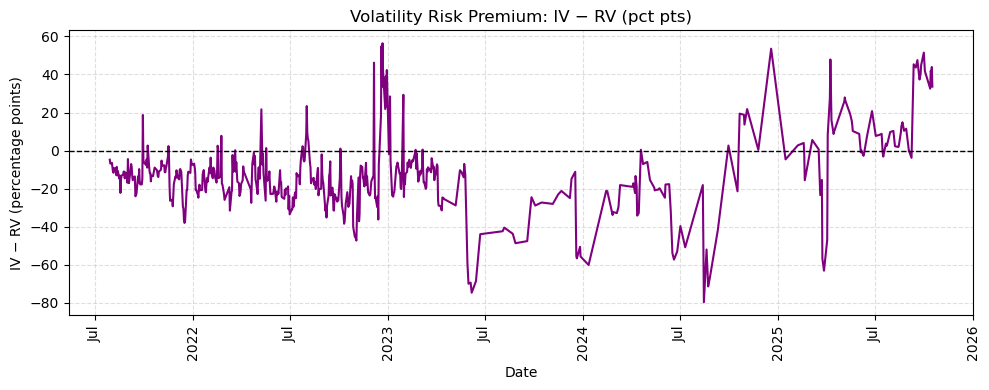

In [ ]:
df_merged["VRP"] = df_merged[iv_col] - df_merged["RV_5d_pct"]

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_merged["Date"], df_merged["VRP"], color="purple")
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_title("Volatility Risk Premium: IV − RV (pct pts)")
ax.set_ylabel("IV − RV (percentage points)")
ax.set_xlabel("Date")

locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# VRP=Implied Volatility−Realized Volatility
# The difference tells you how much extra volatility the market prices in — basically, how much “fear premium” or insurance cost traders are willing to pay for protection.
# Positive (IV > RV) means options are expensive so market is overpricing risk, investors are paying a volatility premium for protection
# Negative (IV < RV) means options are cheap so market is underpricing risk, Market is underpricing risk, actual volatility exceeded expectations

#Selling volatility (e.g., selling options) profits from positive VRP on average.
#Buying volatility (long options) benefits from negative VRP periods.


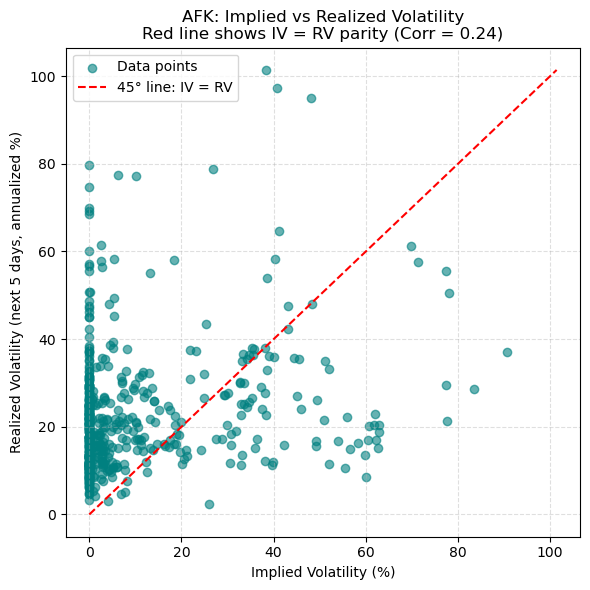

In [ ]:
# Statistical relationship between forecasts (x = IV) and outcomes (y = RV).
#The red 45° parity line represents perfect foresight (IV = RV).
#The slope and clustering reveal how well IV predicts RV.

import matplotlib.pyplot as plt

# Compute correlation (if not already done)
corr = df_merged[iv_col].corr(df_merged["RV_5d_pct"])

# Scatter plot
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(df_merged[iv_col], df_merged["RV_5d_pct"], alpha=0.6, color="teal", label="Data points")

# Red 45° line — perfect parity line (IV = RV)
max_val = df_merged[[iv_col, "RV_5d_pct"]].max().max()
ax.plot([0, max_val], [0, max_val], color="red", linestyle="--", linewidth=1.5, label="45° line: IV = RV")

# Labels & title
ax.set_xlabel("Implied Volatility (%)")
ax.set_ylabel("Realized Volatility (next 5 days, annualized %)")
ax.set_title(f"AFK: Implied vs Realized Volatility\nRed line shows IV = RV parity (Corr = {corr:.2f})")

# Style
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

#That red dashed line in your scatter plot is the 45-degree “parity” line — it shows where points would fall if implied volatility (IV) perfectly matched realized volatility (RV).